In [153]:
# If using CPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
device = ('cpu')

In [26]:
# If using GPU
device = ('cuda')

In [27]:
import numpy as np
import torch
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex=True)
import pandas as pd
import matplotlib.pyplot as plt

### Encoder-Decoder Translation

In [28]:
import urllib
data = []
my_url = "https://raw.githubusercontent.com/luisroque/deep-learning-articles/main/data/eng-por.txt"
with urllib.request.urlopen(my_url) as raw_data:
    for line in raw_data:
        data.append(line.decode("utf-8").split('\t')[0:2])
data = np.array(data)

In [29]:
data.shape

In [30]:
# Subset? - All of the data will take some time...
n_seq = data.shape[0]
n_seq = 10000
data = data[0:n_seq]
split_point = int(data.shape[0] * 0.8) # Keep 80/20 split
np.random.shuffle(data) # In-place modification
max_length = np.max([len(i) for i in data.flatten()]) + 2 # Add start/stop
max_length

45

In [31]:
data[2]

array(["I'm not hungry.", 'Eu não estou com fome.'], dtype='<U184')

In [32]:
i_to_c_eng = ['','<START>','<STOP>'] + list({char for word in data[:,0] for char in word})
c_to_i_eng = {i_to_c_eng[i]:i for i in range(len(i_to_c_eng))}
i_to_c_eng[1] = i_to_c_eng[2] = ''

In [33]:
i_to_c_por = ['','<START>','<STOP>'] + list({char for word in data[:,1] for char in word})
c_to_i_por = {i_to_c_por[i]:i for i in range(len(i_to_c_por))}
i_to_c_por[1] = i_to_c_por[2] = ''

In [34]:
def encode_seq(x,mapping,max_length=0):
    # String to integer
    return [mapping['<START>']] + \
           [mapping[i] for i in list(x)] + \
           [mapping['<STOP>']] + \
           [0]*(max_length-len(list(x))-2)

def decode_seq(x,mapping):
    # Integer-to-string
    try:
        idx = list(x).index(2) # Stop token?
    except:
        idx = len(list(x)) # No stop token found
    return ''.join([mapping[i] for i in list(x)[0:idx]])

In [35]:
data[0]

array(['What happened?', 'O que foi que aconteceu?'], dtype='<U184')

In [36]:
data[0,0]

'What happened?'

In [37]:
temp = encode_seq(data[0,0],c_to_i_eng,max_length)
print(*temp)

1 3 40 36 47 16 40 36 52 52 46 25 46 19 21 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [38]:
decode_seq(temp,i_to_c_eng)

'What happened?'

In [39]:
data[0,1]

'O que foi que aconteceu?'

In [40]:
temp = encode_seq(data[0,1],c_to_i_por,max_length)
print(*temp)

1 57 23 53 26 51 23 3 65 75 23 53 26 51 23 47 20 65 25 13 51 20 51 26 73 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [41]:
decode_seq(temp,i_to_c_por)

'O que foi que aconteceu?'

In [42]:
X = np.vstack([encode_seq(x,c_to_i_eng,max_length) for x in data[:,0]])
Y = np.vstack([encode_seq(x,c_to_i_por,max_length) for x in data[:,1]])

In [43]:
enc_x_train = X[:split_point]
enc_x_val = X[split_point:]
enc_x_train

array([[ 1,  3, 40, ...,  0,  0,  0],
       [ 1, 23, 16, ...,  0,  0,  0],
       [ 1, 23, 49, ...,  0,  0,  0],
       ...,
       [ 1, 71,  9, ...,  0,  0,  0],
       [ 1, 23, 49, ...,  0,  0,  0],
       [ 1, 10,  9, ...,  0,  0,  0]])

In [44]:
dec_x_train = Y[:,0:-1][:split_point]
dec_x_val = Y[:,0:-1][split_point:]
dec_x_train

array([[ 1, 57, 23, ...,  0,  0,  0],
       [ 1, 67, 65, ...,  0,  0,  0],
       [ 1, 39, 26, ...,  0,  0,  0],
       ...,
       [ 1, 77, 79, ...,  0,  0,  0],
       [ 1, 39, 26, ...,  0,  0,  0],
       [ 1, 39, 61, ...,  0,  0,  0]])

In [45]:
dec_y_train = Y[:,1:][:split_point]
dec_y_val = Y[:,1:][split_point:]
dec_y_train

array([[57, 23, 53, ...,  0,  0,  0],
       [67, 65, 61, ...,  0,  0,  0],
       [39, 26, 23, ...,  0,  0,  0],
       ...,
       [77, 79, 65, ...,  0,  0,  0],
       [39, 26, 23, ...,  0,  0,  0],
       [39, 61, 13, ...,  0,  0,  0]])

In [46]:
print(enc_x_train.shape)
print(dec_x_train.shape)
print(dec_y_train.shape)

(8000, 45)
(8000, 44)
(8000, 44)


In [47]:
print(enc_x_val.shape)
print(dec_x_val.shape)
print(dec_y_val.shape)

(2000, 45)
(2000, 44)
(2000, 44)


In [48]:
len(i_to_c_eng)

In [49]:
len(i_to_c_por)

In [50]:
enc_x_train.shape[1:]

# Encoder-Decoder Network

In [51]:
class RecurrentResidual(torch.nn.Module):
    def __init__(self,
                 latent_size = 64,
                 bidirectional = False,
                 **kwargs):
        super().__init__(**kwargs)
        self.layer_norm = torch.nn.LayerNorm(latent_size)
        self.rnn_layer = torch.nn.LSTM(latent_size,
                                       latent_size // 2 if bidirectional else latent_size,
                                       bidirectional=bidirectional,
                                       batch_first=True)
    def forward(self, x):
        return x + self.rnn_layer(self.layer_norm(x))[0]

### Encoder Component

In [52]:
class EncoderNetwork(torch.nn.Module):
    def __init__(self,
                 num_tokens,
                 latent_size = 64, # Use something divisible by 2
                 n_layers = 8,
                 **kwargs):
        super().__init__(**kwargs)
        self.embedding = torch.nn.Embedding(num_tokens,
                                            latent_size,
                                            padding_idx=0)
        self.dropout = torch.nn.Dropout1d(0.1) # Whole token dropped
        self.rnn_layers = torch.nn.Sequential(*[
            RecurrentResidual(latent_size,True) for _ in range(n_layers)
        ])

    def forward(self, x):
        y = x
        y = self.embedding(y)
        y = self.dropout(y)
        y = self.rnn_layers(y)[:,-1]
        return y                                    

In [53]:
enc_x_train[0:5].shape

In [54]:
enc_net = EncoderNetwork(num_tokens=len(i_to_c_eng))

summary(enc_net,input_data=torch.Tensor(enc_x_train[0:5]).long())

Layer (type:depth-idx)                   Output Shape              Param #
EncoderNetwork                           [5, 64]                   --
├─Embedding: 1-1                         [5, 45, 64]               4,672
├─Dropout1d: 1-2                         [5, 45, 64]               --
├─Sequential: 1-3                        [5, 45, 64]               --
│    └─RecurrentResidual: 2-1            [5, 45, 64]               --
│    │    └─LayerNorm: 3-1               [5, 45, 64]               128
│    │    └─LSTM: 3-2                    [5, 45, 64]               25,088
│    └─RecurrentResidual: 2-2            [5, 45, 64]               --
│    │    └─LayerNorm: 3-3               [5, 45, 64]               128
│    │    └─LSTM: 3-4                    [5, 45, 64]               25,088
│    └─RecurrentResidual: 2-3            [5, 45, 64]               --
│    │    └─LayerNorm: 3-5               [5, 45, 64]               128
│    │    └─LSTM: 3-6                    [5, 45, 64]               25,0

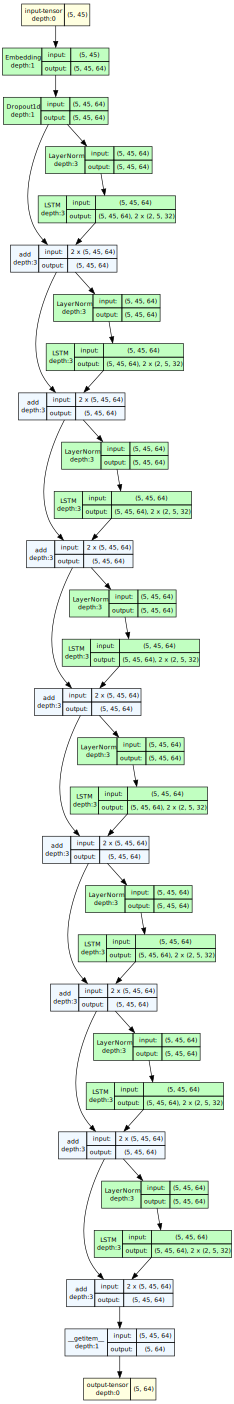

In [55]:
model_graph = draw_graph(enc_net, input_data=torch.Tensor(enc_x_train[0:5]).long(), device=device,
                        hide_inner_tensors=True,hide_module_functions=True,
                        expand_nested=False, depth=3, dtypes=[torch.long])
model_graph.visual_graph

### Decoder Component

In [56]:
class DecoderNetwork(torch.nn.Module):
    def __init__(self,
                 num_tokens,
                 latent_size = 64, # Use something divisible by 2
                 n_layers = 8,
                 **kwargs):
        super().__init__(**kwargs)
        self.embedding = torch.nn.Embedding(num_tokens,
                                            latent_size,
                                            padding_idx=0)
        self.dropout = torch.nn.Dropout1d(0.1) # Whole token dropped
        self.linear = torch.nn.Linear(latent_size*2,
                                      latent_size)
        self.rnn_layers = torch.nn.Sequential(*[
            RecurrentResidual(latent_size,False) for _ in range(n_layers)
        ])
        self.output_layer = torch.nn.Linear(latent_size,
                                            num_tokens)

    def forward(self, x_enc, x_dec):
        y_enc = x_enc.unsqueeze(1).repeat(1,x_dec.shape[1],1)
        y_dec = self.embedding(x_dec)
        y_dec = self.dropout(y_dec)
        y = y_enc
        y = torch.concatenate([y_enc,y_dec],-1)
        y = self.linear(y)
        y = self.rnn_layers(y)
        y = self.output_layer(y)
        return y                                    

In [57]:
enc_x_train[0:5].shape

In [58]:
dec_x_train[0:5].shape

In [59]:
enc_net(torch.Tensor(enc_x_train[0:5]).long().to(device))

tensor([[ 1.6525e-01, -7.7133e-01,  6.2579e-02, -1.4571e+00, -5.4212e-01,
         -7.0020e-01, -8.9992e-01,  9.6750e-01,  7.7245e-02, -7.1350e-01,
         -2.0515e-01, -6.8371e-01,  6.4568e-01, -8.8455e-02, -3.6113e-01,
          1.0798e-01,  1.0411e-01,  5.2122e-02,  8.9214e-01,  9.3352e-01,
          4.1456e-01,  3.4689e-01,  5.0991e-01, -3.0799e-01, -2.8118e-01,
         -1.3983e+00, -1.7681e-01, -5.2543e-01,  8.2318e-01, -9.6934e-02,
         -6.5933e-01, -1.6629e-01, -2.6267e-01,  2.3271e-01,  2.0543e-01,
         -1.0934e-01,  4.9774e-01,  1.1392e-01,  7.2854e-01,  2.7520e-01,
         -1.3371e-01,  3.1289e-03, -4.6270e-01, -1.4000e-01, -3.5630e-01,
         -9.9907e-02, -2.6424e-01,  5.5670e-01,  4.8850e-01, -3.6646e-01,
         -1.9660e-01,  1.6988e-01, -6.4384e-01,  5.3466e-01,  1.0886e-01,
          2.6764e-01, -5.3462e-03, -3.7833e-01,  3.7225e-01, -4.0995e-02,
         -5.1791e-01,  4.9058e-01,  7.7219e-01, -4.8448e-02],
        [ 1.6370e-01, -7.7176e-01,  6.1661e-02, -1

In [60]:
dec_net = DecoderNetwork(num_tokens=len(i_to_c_por))

summary(dec_net,input_data=[enc_net(torch.Tensor(enc_x_train[0:5]).long().to(device)).cpu(),
                            torch.Tensor(dec_x_train[0:5]).long()])

Layer (type:depth-idx)                   Output Shape              Param #
DecoderNetwork                           [5, 44, 87]               --
├─Embedding: 1-1                         [5, 44, 64]               5,568
├─Dropout1d: 1-2                         [5, 44, 64]               --
├─Linear: 1-3                            [5, 44, 64]               8,256
├─Sequential: 1-4                        [5, 44, 64]               --
│    └─RecurrentResidual: 2-1            [5, 44, 64]               --
│    │    └─LayerNorm: 3-1               [5, 44, 64]               128
│    │    └─LSTM: 3-2                    [5, 44, 64]               33,280
│    └─RecurrentResidual: 2-2            [5, 44, 64]               --
│    │    └─LayerNorm: 3-3               [5, 44, 64]               128
│    │    └─LSTM: 3-4                    [5, 44, 64]               33,280
│    └─RecurrentResidual: 2-3            [5, 44, 64]               --
│    │    └─LayerNorm: 3-5               [5, 44, 64]               12

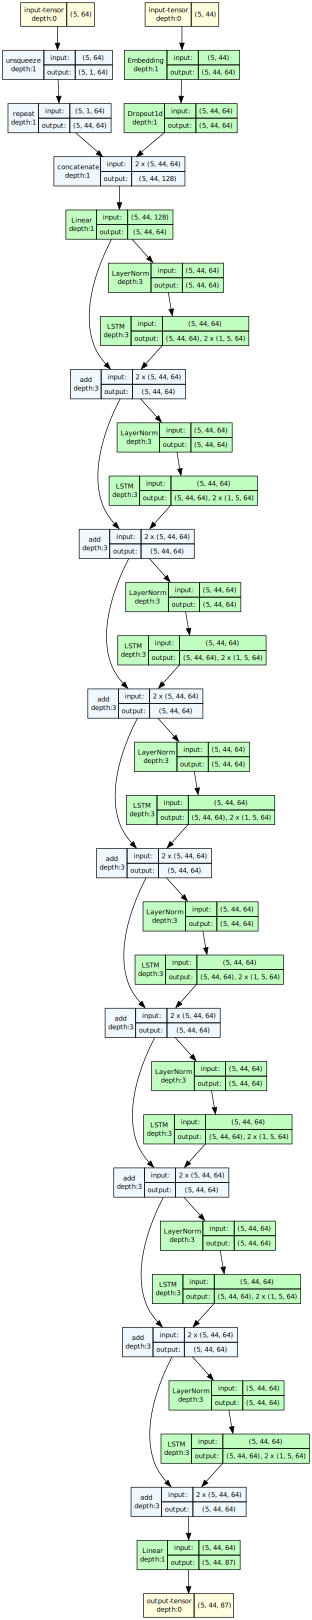

In [61]:
model_graph = draw_graph(dec_net, input_data=[enc_net(torch.Tensor(enc_x_train[0:5]).long().to(device)).cpu(),
                            torch.Tensor(dec_x_train[0:5]).long()], device=device,
                        hide_inner_tensors=True,hide_module_functions=True,
                        expand_nested=False, depth=3, dtypes=[torch.long])
model_graph.visual_graph

### Training Hooks

In [62]:
class EncDecLightningModule(pl.LightningModule):
    def __init__(self,
                 output_size,
                 **kwargs):
        super().__init__(**kwargs)
        self.mc_acc = torchmetrics.classification.Accuracy(task='multiclass',
                                                           num_classes=output_size,
                                                           ignore_index=0)
        self.cce_loss = torch.nn.CrossEntropyLoss(ignore_index=0)

    def predict(self, x):
        return torch.softmax(self(x),-1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x_enc, x_dec, y_dec = train_batch
        y_pred = self(x_enc, x_dec)
        perm = (0,-1) + tuple(range(y_pred.ndim))[1:-1]
        acc = self.mc_acc(y_pred.permute(*perm),y_dec)
        loss = self.cce_loss(y_pred.permute(*perm),y_dec)
        self.log('train_acc', acc, on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    # Validate used for Teacher Forcing
    def validation_step(self, val_batch, batch_idx):
        x_enc, x_dec, y_dec = val_batch
        y_pred = self(x_enc, x_dec)
        perm = (0,-1) + tuple(range(y_pred.ndim))[1:-1]
        acc = self.mc_acc(y_pred.permute(*perm),y_dec)
        loss = self.cce_loss(y_pred.permute(*perm),y_dec)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss

    # Test used for Non-Teacher Forcing
    def test_step(self, test_batch, batch_idx):
        x_enc, x_dec, y_dec = test_batch
        context = self.enc_net(x_enc)
        tokens = torch.zeros_like(x_dec).long()
        tokens[:,0] = 1
        for i in range(y_dec.shape[1]-1):
            tokens[:,i+1] = self.dec_net(context, tokens).argmax(-1)[:,i]
        y_pred = self(x_enc, tokens)
        perm = (0,-1) + tuple(range(y_pred.ndim))[1:-1]
        acc = self.mc_acc(y_pred.permute(*perm),y_dec)
        loss = self.cce_loss(y_pred.permute(*perm),y_dec)
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss


### Encoder-Decoder Network

In [63]:
class EncDecNetwork(EncDecLightningModule):
    def __init__(self,
                 num_enc_tokens,
                 num_dec_tokens,
                 latent_size = 64, # Use something divisible by 2
                 n_layers = 8,
                 **kwargs):
        super().__init__(output_size=num_dec_tokens,
                         **kwargs)
        self.enc_net = EncoderNetwork(num_enc_tokens,latent_size,n_layers)
        self.dec_net = DecoderNetwork(num_dec_tokens,latent_size,n_layers)

    def forward(self, x_enc, x_dec):
        return self.dec_net(self.enc_net(x_enc), x_dec)

In [64]:
enc_dec_net = EncDecNetwork(num_enc_tokens=len(i_to_c_eng),
                            num_dec_tokens=len(i_to_c_por))
summary(enc_dec_net,input_data=[torch.Tensor(enc_x_train[0:1]).long(),
                                torch.Tensor(dec_x_train[0:1]).long()])

Layer (type:depth-idx)                   Output Shape              Param #
EncDecNetwork                            [1, 44, 87]               --
├─EncoderNetwork: 1-1                    [1, 64]                   --
│    └─Embedding: 2-1                    [1, 45, 64]               4,672
│    └─Dropout1d: 2-2                    [1, 45, 64]               --
│    └─Sequential: 2-3                   [1, 45, 64]               --
│    │    └─RecurrentResidual: 3-1       [1, 45, 64]               25,216
│    │    └─RecurrentResidual: 3-2       [1, 45, 64]               25,216
│    │    └─RecurrentResidual: 3-3       [1, 45, 64]               25,216
│    │    └─RecurrentResidual: 3-4       [1, 45, 64]               25,216
│    │    └─RecurrentResidual: 3-5       [1, 45, 64]               25,216
│    │    └─RecurrentResidual: 3-6       [1, 45, 64]               25,216
│    │    └─RecurrentResidual: 3-7       [1, 45, 64]               25,216
│    │    └─RecurrentResidual: 3-8       [1, 45, 64]  

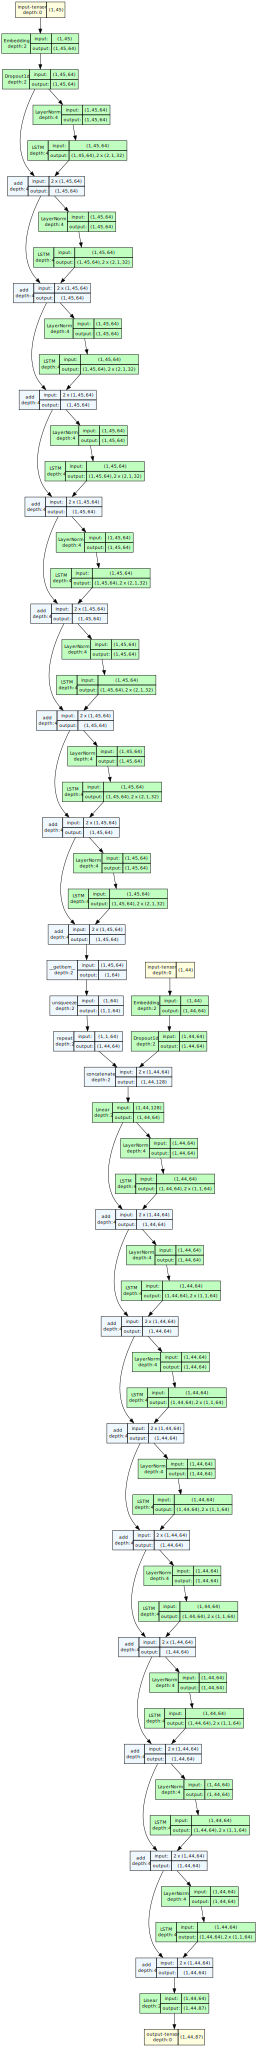

In [65]:
model_graph = draw_graph(enc_dec_net,
                         input_data=[torch.Tensor(enc_x_train[0:1]).long(),
                                     torch.Tensor(dec_x_train[0:1]).long()],
                         device=device,
                         hide_inner_tensors=True,hide_module_functions=True,
                         expand_nested=False, depth=4, dtypes=[torch.long])
model_graph.visual_graph

### Training Time

In [67]:
batch_size = 128
xy_train = torch.utils.data.DataLoader(list(zip(torch.Tensor(enc_x_train).long(),
                                                torch.Tensor(dec_x_train).long(),
                                                torch.Tensor(dec_y_train).long())),
                                       shuffle=True, batch_size=batch_size,
                                       num_workers=8)
xy_val = torch.utils.data.DataLoader(list(zip(torch.Tensor(enc_x_val).long(),
                                              torch.Tensor(dec_x_val).long(),
                                              torch.Tensor(dec_y_val).long())),
                                     shuffle=False, batch_size=batch_size,
                                     num_workers=8)

In [68]:
logger = pl.loggers.CSVLogger("lightning_logs",
                              name="Demo-2023-04-07",
                              version="demo-0")

In [69]:
trainer = pl.Trainer(logger=logger,
                     max_epochs=300,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=False,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [70]:
trainer.validate(enc_dec_net, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │   0.012901436537504196    │
│         val_loss          │     4.494296550750732     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.012901436537504196, 'val_loss': 4.494296550750732}]

In [71]:
trainer.test(enc_dec_net, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.0037423693574965     │
│         test_loss         │     4.639850616455078     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.0037423693574965, 'test_loss': 4.639850616455078}]

In [72]:
# Saving - be careful
import pickle
with open(logger.log_dir+"/mappings","wb") as f:
    pickle.dump(i_to_c_eng,f)
    pickle.dump(c_to_i_eng,f)
    pickle.dump(i_to_c_por,f)
    pickle.dump(c_to_i_por,f)
    pickle.dump(encode_seq,f)
    pickle.dump(decode_seq,f)

In [73]:
trainer.fit(enc_dec_net, xy_train, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | mc_acc   | MulticlassAccuracy | 0     
1 | cce_loss | CrossEntropyLoss   | 0     
2 | enc_net  | EncoderNetwork     | 206 K 
3 | dec_net  | DecoderNetwork     | 286 K 
------------------------------------------------
493 K     Trainable params
0         Non-trainable params
493 K     Total params
1.973     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


In [74]:
with open(logger.log_dir+"/mappings","rb") as f:
    pickle.load(f)

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


In [75]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

,val_acc,val_loss,epoch,step,test_acc,test_loss,train_acc,train_loss
0,0.012901,4.494297,0,0,NaN,NaN,NaN,NaN
1,NaN,NaN,0,0,0.003742,4.639851,NaN,NaN
2,0.380803,2.124042,0,62,NaN,NaN,NaN,NaN
3,NaN,NaN,0,62,NaN,NaN,0.276535,2.707716
4,0.453643,1.848870,1,125,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
597,NaN,NaN,297,18773,NaN,NaN,0.830124,0.520423
598,0.760862,0.947743,298,18836,NaN,NaN,NaN,NaN
599,NaN,NaN,298,18836,NaN,NaN,0.830254,0.518234
600,0.756943,0.956585,299,18899,NaN,NaN,NaN,NaN


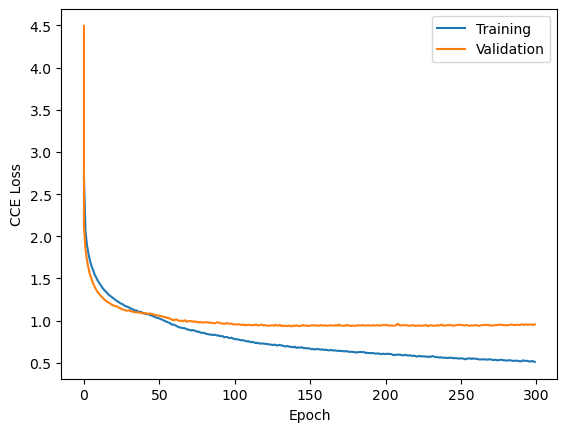

In [76]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))],
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))],
         label="Validation")
plt.legend()
plt.ylabel("CCE Loss")
plt.xlabel("Epoch")
plt.show()

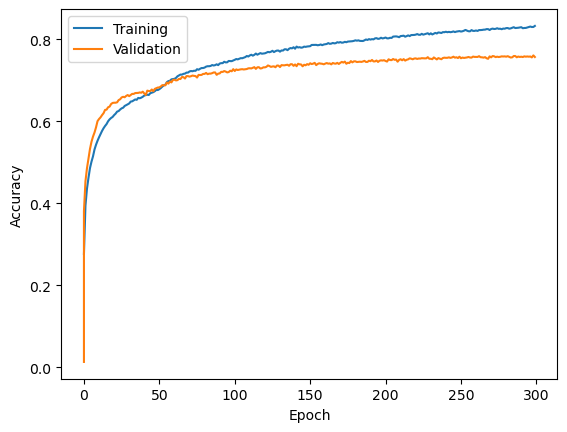

In [77]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_acc"]))],
         results["train_acc"][np.logical_not(np.isnan(results["train_acc"]))],
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_acc"]))],
         results["val_acc"][np.logical_not(np.isnan(results["val_acc"]))],
         label="Validation")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

# Direct Validation of Results

### Teacher Forcing

In [78]:
# What should we see?
i = 0
print('Input:', enc_x_val[i])
print('Output:', dec_y_val[i])

Input: [ 1 23 16 22 36 69 25 49 47 16 40 36 52 52 29 61  2  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Output: [77 79 65 23 51 61 13 47 55 47 23  3 51 41 75 31 58  2  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [79]:
print('Input:', decode_seq(enc_x_val[i],i_to_c_eng))
print('Output:', decode_seq(dec_y_val[i],i_to_c_por))

Input: I wasn't happy.
Output: Não estava feliz.


In [82]:
result = enc_dec_net(torch.Tensor(enc_x_val[i:i+1]).long(),
                     torch.Tensor(dec_x_val[i:i+1]).long()).cpu().detach().numpy()
result.argmax(-1)[0]

array([39, 79, 65, 23, 54, 82, 13, 47, 55, 47, 23, 15, 82, 82, 75, 71, 58,
        2, 47, 25, 47, 47, 23, 58,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2, 65, 65, 65, 65, 65, 65, 65])

In [83]:
# Only if the above fails due to device management reasons...
# result = enc_dec_net(torch.Tensor(enc_x_val[i:i+1]).long().to(device),
#                      torch.Tensor(dec_x_val[i:i+1]).long().to(device)).cpu().detach().numpy()
# result.argmax(-1)[0]

In [84]:
decode_seq(result.argmax(-1)[0],i_to_c_por)

'Eão mrtava prrid.'

In [85]:
trainer.validate(enc_dec_net, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.7569431662559509     │
│         val_loss          │    0.9565846920013428     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.7569431662559509, 'val_loss': 0.9565846920013428}]

### Non-Teacher Forcing

In [86]:
# Get the gestalt context for the input sequence(s)
context = enc_dec_net.enc_net(torch.Tensor(enc_x_val[i:i+1]).long())

# Prep a starting token...
token = torch.zeros((1,dec_y_val.shape[1])).long()
token[0,0] = 1
token

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [87]:
# What do we get with just one pass?
result = enc_dec_net.dec_net(context,token)
result.cpu().detach().numpy().argmax(-1)[0]

array([39, 26, 65, 25, 65, 65, 65, 26, 23, 23, 23, 23, 23, 23, 23, 23, 23,
       65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2])

In [88]:
decode_seq(result.cpu().detach().numpy().argmax(-1)[0],i_to_c_por)

'Euonooou         ooooooooooooo'

In [89]:
token[0,1] = result[0,0].argmax(-1)
token

tensor([[ 1, 39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0]])

In [90]:
# Feed next token in...
result = enc_dec_net.dec_net(context,token)
result.cpu().detach().numpy().argmax(-1)[0]

array([39, 26, 23, 25, 79, 65, 23, 26, 65, 65, 23, 23, 23, 23, 23, 23, 23,
       23, 23, 23, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2])

In [91]:
decode_seq(result.cpu().detach().numpy().argmax(-1)[0],i_to_c_por)

'Eu não uoo          ooooooooooo'

### Complete Sequence with Non-Teacher Forcing

In [92]:
# Complete max_length cycles with the decoder
context = enc_dec_net.enc_net(torch.Tensor(enc_x_val[i:i+1]).long())
token = torch.zeros((1,dec_y_val.shape[1])).long()
token[0,0] = 1

for x in range(dec_y_val.shape[1]-1):
    result = enc_dec_net.dec_net(context,token).argmax(-1)
    if result[0,x] == 2:
        break
    token[0,x+1] = result[0,x]
result = enc_dec_net.dec_net(context,token).argmax(-1).cpu().detach().numpy()[0]
result

array([39, 26, 23, 25, 79, 65, 23, 54, 51, 23, 54, 47, 12, 75, 58,  2, 58,
        2, 23,  2, 65, 71,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2])

In [93]:
decode_seq(result,i_to_c_por)

'Eu não me maxi.'

In [94]:
result.shape

In [95]:
dec_y_val.shape

Accuracy **without** teacher forcing...

In [96]:
trainer.test(enc_dec_net, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.295718789100647     │
│         test_loss         │      8.5599365234375      │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.295718789100647, 'test_loss': 8.5599365234375}]